## Задача
Проанализировать сообщества пользователя во Вконтакте: 
1. Найти сообщества, с наибольшим общим количеством друзей 
2. Найти сообщества, с наибольшим общим количеством друзей друзей пользователя
3. Предложить гипотезу по применению полученной информации

In [ ]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pylab as plt
from tqdm.auto import tqdm

%matplotlib inline
sns.set(rc={'figure.figsize':(15,9)}, style='whitegrid')

In [ ]:
%pip install vk_api

  Created wheel for vk-api: filename=vk_api-11.9.1-cp36-none-any.whl size=44097 sha256=e1422180a244b2dfc3e2af55b9dee62820374f2d5d9379f6088fcf91ebb94f4e
  Stored in directory: /root/.cache/pip/wheels/fc/43/59/8fba75529a5b85d5ff706007d699ab18bb90b7b54e074797c5
Successfully built vk-api


In [ ]:
import vk_api



---

---





## 1.

In [ ]:

def auth_handler():
    """ При двухфакторной аутентификации вызывается эта функция.
    """
    # Код двухфакторной аутентификации
    key = input("Enter authentication code: ")
    # Если: True - сохранить, False - не сохранять.
    remember_device = True
    return key, remember_device

def vk_session_init(user_login, user_password):
  vk_session = vk_api.VkApi(
    user_login, user_password,
    auth_handler=auth_handler # функция для обработки двухфакторной аутентификации
  )
  return vk_session

In [ ]:
user_login = ''
user_password = ''
vk_session = vk_session_init(user_login, user_password)
try:
    vk_session.auth()
except vk_api.AuthError as error_msg:
    print(error_msg)
vk = vk_session.get_api()

Enter authentication code: 265715


Получим список групп пользователя, список друзей и список групп друзей, а в конце объединим эти два списка.

In [46]:
#user_id = vk.users.get()[0]['id'] #получаем id авторизованного пользователя
user_id = 55420799
#user_id

In [ ]:
user_groups_df = pd.read_csv('user_groups_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
user_groups = vk.groups.get(user_id=user_id, extended=1)
user_groups_df = pd.DataFrame(user_groups['items'])
user_groups_df['user_id'] = user_id
user_groups_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,admin_level,user_id
0,125004421,Настоящий Лентач,true_lentach,0,page,0,1,0,https://sun1-17.userapi.com/s/v1/ig2/35DtoNB6E...,https://sun1-17.userapi.com/s/v1/ig2/6ajcAns_T...,https://sun1-17.userapi.com/s/v1/ig2/JjkFmbalT...,NaN,55420799
1,33880573,THE DUMP,dumpers,0,page,0,1,0,https://sun1-24.userapi.com/s/v1/if1/099Fhum7g...,https://sun1-24.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun1-24.userapi.com/s/v1/if1/LKWp0K0Sv...,NaN,55420799
2,169934613,KARPOV.COURSES,karpovcourses,0,page,0,1,0,https://sun1-99.userapi.com/s/v1/ig2/C1Ke892N5...,https://sun1-99.userapi.com/s/v1/ig2/wrGIlPa-_...,https://sun1-99.userapi.com/s/v1/ig2/cAbZcIBLF...,NaN,55420799
3,31480508,Пикабу,pikabu,0,page,0,1,0,https://sun1-16.userapi.com/s/v1/if1/v0HEGsil2...,https://sun1-16.userapi.com/s/v1/if1/SKPh1hvjc...,https://sun1-16.userapi.com/s/v1/if1/qLMUnORnQ...,NaN,55420799
4,20629724,Хабр,habr,0,page,0,1,0,https://sun1-84.userapi.com/s/v1/ig1/cvgInBNS_...,https://sun1-84.userapi.com/s/v1/ig1/eMUYlx1UV...,https://sun1-84.userapi.com/s/v1/ig1/xiDx2spXM...,NaN,55420799


In [ ]:
user_groups_df.shape

(243, 14)

In [ ]:
user_groups_df.to_csv('user_groups_df.csv')

In [ ]:
user_friends_list = vk.friends.get(user_id=user_id)['items']

In [ ]:
pd.DataFrame(user_friends_list).to_csv('user_friends_list.csv')

In [ ]:
friends_groups_df = pd.read_csv('friends_groups_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
friends_groups_df = pd.DataFrame()

for friend in user_friends_list:
  try:
    friend_groups_df = pd.DataFrame(vk.groups.get(user_id=friend, extended=1, v=5.126)['items'])
    friend_groups_df['user_id'] = friend
    friends_groups_df = pd.concat([friends_groups_df, friend_groups_df], axis=0)
  except vk_api.exceptions.VkApiError:
    print(f'ApiError по пользователю {friend}')
    continue

In [ ]:
friends_groups_df.to_csv('friends_groups_df.csv') #опционально

In [ ]:
friends_groups_df.shape

(12910, 14)

In [ ]:
friends_groups_df.head()

,Unnamed: 0,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_id,deactivated
0,0,92307020.0,"Тамара, какого хрена?",odonata_live,0.0,page,0.0,0.0,0.0,https://sun1-22.userapi.com/impf/c836734/v8367...,https://sun1-22.userapi.com/impf/c836734/v8367...,https://sun1-22.userapi.com/impf/c836734/v8367...,56840,NaN
1,1,194622716.0,Linxdatacenter,linxdc,0.0,page,0.0,1.0,0.0,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,56840,NaN
2,2,68696990.0,Удивительная Япония,paradoks_japan,0.0,page,0.0,0.0,0.0,https://sun1-29.userapi.com/impf/c624524/v6245...,https://sun1-29.userapi.com/impf/c624524/v6245...,https://sun1-29.userapi.com/impf/c624524/v6245...,56840,NaN
3,3,60394841.0,Неизвестная Россия,unknown_russia,0.0,page,0.0,0.0,0.0,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,56840,NaN
4,4,53895074.0,Питертранспорт | Изменения маршрутов,pitertransport_routes,0.0,page,0.0,0.0,0.0,https://sun1-90.userapi.com/impf/c638121/v6381...,https://sun1-90.userapi.com/impf/c638121/v6381...,https://sun1-90.userapi.com/impf/c638121/v6381...,56840,NaN


In [ ]:
friends_groups_df = friends_groups_df[friends_groups_df.deactivated.isna()] # отбираем записи только активных пользователей
friends_groups_df.shape

(12772, 14)

In [ ]:
merged_df = pd.read_csv('merged_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
merged_df = pd.concat([friends_groups_df, user_groups_df], axis=0)
merged_df.id = merged_df.id.astype('int')

In [ ]:
merged_df.to_csv('merged_df.csv') #опционально

In [ ]:
merged_df.shape

(13151, 16)

In [70]:
#friends_groups_df = merged_df.query("user_id != @user_id")

Проанализируем самые популярные группы среди друзей пользователя, а также пересечения с пользователем

In [72]:
freinds_groups_freq = friends_groups_df.groupby(['id', 'name'], as_index=False)['type']\
         .count()\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
freinds_groups_freq.head()

,id,name,count
1590,31480508,Пикабу,24
4206,63731512,Vandrouki | Путешествия почти бесплатно (RU),21
1375,29534144,Лентач,21
2102,36338110,KudaGo: Санкт-Петербург,20
1125,26762265,Томские.ру,16


In [79]:
common_groups_freq = merged_df[merged_df.id.isin(user_groups_df.id)].groupby(['id', 'name'], as_index=False)\
         .agg({'type':'count'})\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
common_groups_freq.head()

,id,name,count
71,31480508,Пикабу,25
131,63731512,Vandrouki | Путешествия почти бесплатно (RU),22
62,29534144,Лентач,22
155,76982440,«Медуза»,14
43,24098496,E.squirе,14


In [74]:
def group_freq_vizualization(data_x_1, data_y_1, data_x_2, data_y_2, title_1='Common groups', title_2='Friends groups', count_groups=30, len_tick = 15):
  f = plt.figure(figsize=(20, 8))
  gs = f.add_gridspec(1, 2)

  ax = f.add_subplot(gs[0, 0])
  sns.barplot(x=data_x_1[:count_groups], y=data_y_1[:count_groups], saturation=.3, color='blue')
  ax.set_title(title_1)
  yticks_1 = data_y_1[:count_groups] #названия групп бывают довольно длинные, ограничим их
  yticks_1 = [x if len(x) < len_tick else x[0:len_tick] + '...' for x in yticks_1]
  ax.set_yticklabels(yticks_1)
  ax.set_ylabel('')

  ax = f.add_subplot(gs[0, 1])
  sns.barplot(x=data_x_2[:count_groups], y=data_y_2[:count_groups], saturation=.3, color='blue')
  ax.set_title('Friends groups')
  yticks_2 = data_y_2[:count_groups] #названия групп бывают довольно длинные, ограничим их
  yticks_2 = [x if len(x) < len_tick else x[0:len_tick] + '...' for x in yticks_2]
  ax.set_yticklabels(yticks_2)
  ax.set_ylabel('')
  f.tight_layout()

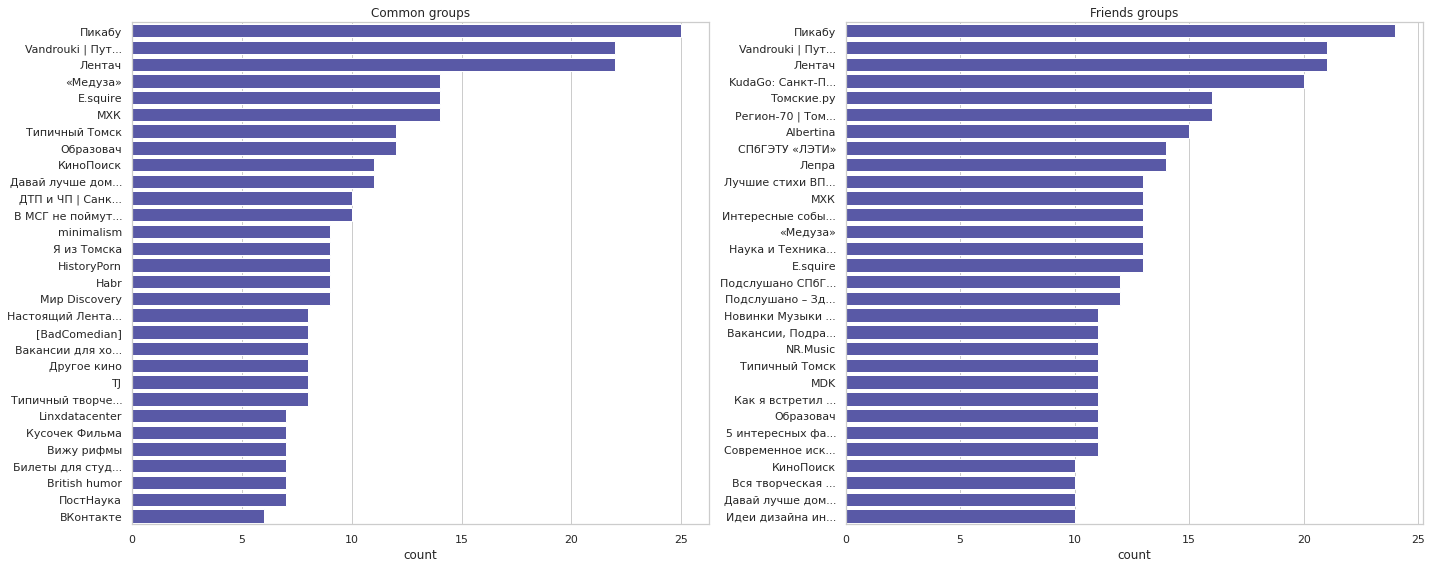

In [75]:
group_freq_vizualization(common_groups_freq['count'], common_groups_freq['name'], freinds_groups_freq['count'], freinds_groups_freq['name'] )

Выше представлена графики распределения количества общих групп пользователя и его друзей и отдельно по группам друзей. Можно сразу отметить полное совпадение Топ-3 групп - все мы любим смешные картинки, интересные истории и желание недорого путешествовать.

Также сразу бросается в глаза, что большое количество общих друзей в группах относятся к двум городам - Томск и Санкт-Петербург, видимо, пользователь тесно связан с этими городами. 

## 2

Соберём информацию о группах друзей друзей пользователя.
Найдем самые популярные

Получим список друзей друзей пользователя

In [ ]:
list_friends_of_friends_df = pd.read_csv('list_friends_of_friends_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
list_friends_of_friends_df = pd.DataFrame()

for friend in tqdm(user_friends_list):
  try:
    list_friends_of_friend_df = pd.DataFrame( vk.friends.get(user_id=friend, fields=['first_name', 'last_name'])['items'])
    list_friends_of_friend_df['user_friend_id'] = friend
    list_friends_of_friends_df = pd.concat([list_friends_of_friends_df, list_friends_of_friend_df], axis=0)
  except vk_api.exceptions.VkApiError:
    #print(f'ApiError по пользователю {friend}')
    continue

In [ ]:
print(f'Размер df: {list_friends_of_friends_df.shape}')
print(f"Количество повторяющихся друзей: {list_friends_of_friends_df.duplicated(subset=['id']).sum()}")
list_friends_of_friends_df = list_friends_of_friends_df.drop_duplicates(subset=['id'])
print(f'Размер df после удаления повторов: {list_friends_of_friends_df.shape}')

Размер df: (47299, 9)
Количество повторяющихся друзей: 6252
Размер df после удаления повторов: (41047, 9)


In [ ]:
list_friends_of_friends_df.head()

,first_name,id,last_name,can_access_closed,is_closed,track_code,deactivated,lists,user_friend_id
0,Ms,8554,Dudina,False,True,196598c0UCy8K5xADADrKj5DeTVDsYA0Sx2qMEjpm2Viqi...,NaN,NaN,56840
1,Pavel,8790,Stepanov,False,True,811dfd65kXuWZhjls1uADLOqZ5Ry6tuMPnksX76yMEs3pS...,NaN,NaN,56840
2,Margarita,9598,Konovalova,True,False,a64280d2h7ac_XkuIiopULGahjvct8Spyn1uKeuikEUpiY...,NaN,NaN,56840
3,Alexander,30693,Pchelyakov,True,False,b547a229_nkLrLIXhAqTqov1sD5M_w8a6FJ5NB7F_hRT5Z...,NaN,NaN,56840
4,Ho,35725,Mer,True,False,610a1f0dpHZVvS2zlJgX3u9pXbJ3i_rpMHdEp2HSBGOFuq...,NaN,NaN,56840


In [ ]:
list_friends_of_friends_df.to_csv('list_friends_of_friends_df.csv')

Выгрузим информацию по всем группам друзей друзей пользователя. Выберем только 5000 случайных друзей, чтобы не нагружать API и не делать гигабайтный датасет

In [ ]:
list_groups_of_friends_of_friends_df = pd.read_csv('list_groups_of_friends_of_friends_df_5000.csv', index_col=0) #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
list_groups_of_friends_of_friends_df = pd.DataFrame()

for friend_of_friend in tqdm(list_friends_of_friends_df.sample(5000)['id']):
  try:
    list_groups_of_friend_of_friends_df = pd.DataFrame( vk.groups.get(user_id=friend_of_friend, extended=1, v=5.126)['items'])
    list_groups_of_friend_of_friends_df['user_friend_id'] = friend_of_friend
    list_groups_of_friends_of_friends_df = pd.concat([list_groups_of_friends_of_friends_df, list_groups_of_friend_of_friends_df], axis=0)
  except vk_api.exceptions.VkApiError:
    #print(f'ApiError по пользователю {friend}')
    continue
list_groups_of_friends_of_friends_df.to_csv('list_groups_of_friends_of_friends_df_5000.csv')

In [ ]:
list_groups_of_friends_of_friends_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_friend_id,deactivated
0,33880573.0,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun9-43.userapi.com/s/v1/if1/099Fhum7g...,https://sun9-43.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun9-43.userapi.com/s/v1/if1/LKWp0K0Sv...,15812372,NaN
1,62580435.0,ФРУСТРАЦИЯ,frustrat,0.0,page,0.0,0.0,0.0,https://sun9-45.userapi.com/s/v1/ig1/28y1T1KbX...,https://sun9-45.userapi.com/s/v1/ig1/YfSEt-NBf...,https://sun9-45.userapi.com/s/v1/ig1/l2XRcqDrG...,15812372,NaN
2,72831913.0,Непаблик 18+,nepublic,0.0,page,0.0,0.0,0.0,https://sun9-32.userapi.com/s/v1/if1/hj9ae-VvA...,https://sun9-32.userapi.com/s/v1/if1/PPknx02Xy...,https://sun9-32.userapi.com/s/v1/if1/7vlfXR8cK...,15812372,NaN
3,460389.0,БОРЩ,borsch,0.0,page,0.0,0.0,0.0,https://sun9-38.userapi.com/s/v1/ig2/BkrOgl2tY...,https://sun9-38.userapi.com/s/v1/ig2/qDgXFYZcs...,https://sun9-38.userapi.com/s/v1/ig2/GU2-ZZLl8...,15812372,NaN
4,91795517.0,Салон Бытовых Услуг OKEY в Щелково и Балашихе,okey_s,0.0,page,0.0,0.0,0.0,https://sun9-4.userapi.com/s/v1/ig2/nQWtyYDtPU...,https://sun9-4.userapi.com/s/v1/ig2/8CThOkZWo_...,https://sun9-4.userapi.com/s/v1/ig2/UER9TQaBMi...,15812372,NaN


Посчитаем частоту включений групп друзей друзей пользователя

In [78]:
freinds_of_friends_groups_freq = list_groups_of_friends_of_friends_df.groupby(['id', 'name'], as_index=False)['type']\
         .count()\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
freinds_of_friends_groups_freq.head()

,id,name,count
72502,60130670.0,Регион-70 | Томск,323
26251,30022666.0,Лепра,314
68710,57846937.0,MDK,305
25505,29534144.0,Лентач,278
77342,63731512.0,Vandrouki | Путешествия почти бесплатно (RU),275


Объединим массивы, чтобы было удобнее сравнивать и считать группы

In [ ]:
merged_friends_of_friends_df = pd.concat([list_groups_of_friends_of_friends_df, user_groups_df], axis=0)
merged_friends_of_friends_df.shape

(415375, 16)

In [ ]:
merged_friends_of_friends_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_friend_id,deactivated,Unnamed: 0,admin_level,user_id
0,33880573.0,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun9-43.userapi.com/s/v1/if1/099Fhum7g...,https://sun9-43.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun9-43.userapi.com/s/v1/if1/LKWp0K0Sv...,15812372.0,NaN,NaN,NaN,NaN
1,62580435.0,ФРУСТРАЦИЯ,frustrat,0.0,page,0.0,0.0,0.0,https://sun9-45.userapi.com/s/v1/ig1/28y1T1KbX...,https://sun9-45.userapi.com/s/v1/ig1/YfSEt-NBf...,https://sun9-45.userapi.com/s/v1/ig1/l2XRcqDrG...,15812372.0,NaN,NaN,NaN,NaN
2,72831913.0,Непаблик 18+,nepublic,0.0,page,0.0,0.0,0.0,https://sun9-32.userapi.com/s/v1/if1/hj9ae-VvA...,https://sun9-32.userapi.com/s/v1/if1/PPknx02Xy...,https://sun9-32.userapi.com/s/v1/if1/7vlfXR8cK...,15812372.0,NaN,NaN,NaN,NaN
3,460389.0,БОРЩ,borsch,0.0,page,0.0,0.0,0.0,https://sun9-38.userapi.com/s/v1/ig2/BkrOgl2tY...,https://sun9-38.userapi.com/s/v1/ig2/qDgXFYZcs...,https://sun9-38.userapi.com/s/v1/ig2/GU2-ZZLl8...,15812372.0,NaN,NaN,NaN,NaN
4,91795517.0,Салон Бытовых Услуг OKEY в Щелково и Балашихе,okey_s,0.0,page,0.0,0.0,0.0,https://sun9-4.userapi.com/s/v1/ig2/nQWtyYDtPU...,https://sun9-4.userapi.com/s/v1/ig2/8CThOkZWo_...,https://sun9-4.userapi.com/s/v1/ig2/UER9TQaBMi...,15812372.0,NaN,NaN,NaN,NaN


In [77]:
commons_friends_of_friends_groups_freq = merged_friends_of_friends_df[merged_friends_of_friends_df.id.isin(user_groups_df.id)].groupby(['id', 'name'], as_index=False)\
         .agg({'type':'count'})\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
commons_friends_of_friends_groups_freq.head()

,id,name,count
62,29534144.0,Лентач,279
131,63731512.0,Vandrouki | Путешествия почти бесплатно (RU),276
71,31480508.0,Пикабу,268
43,24098496.0,E.squirе,188
38,22822305.0,ВКонтакте,177


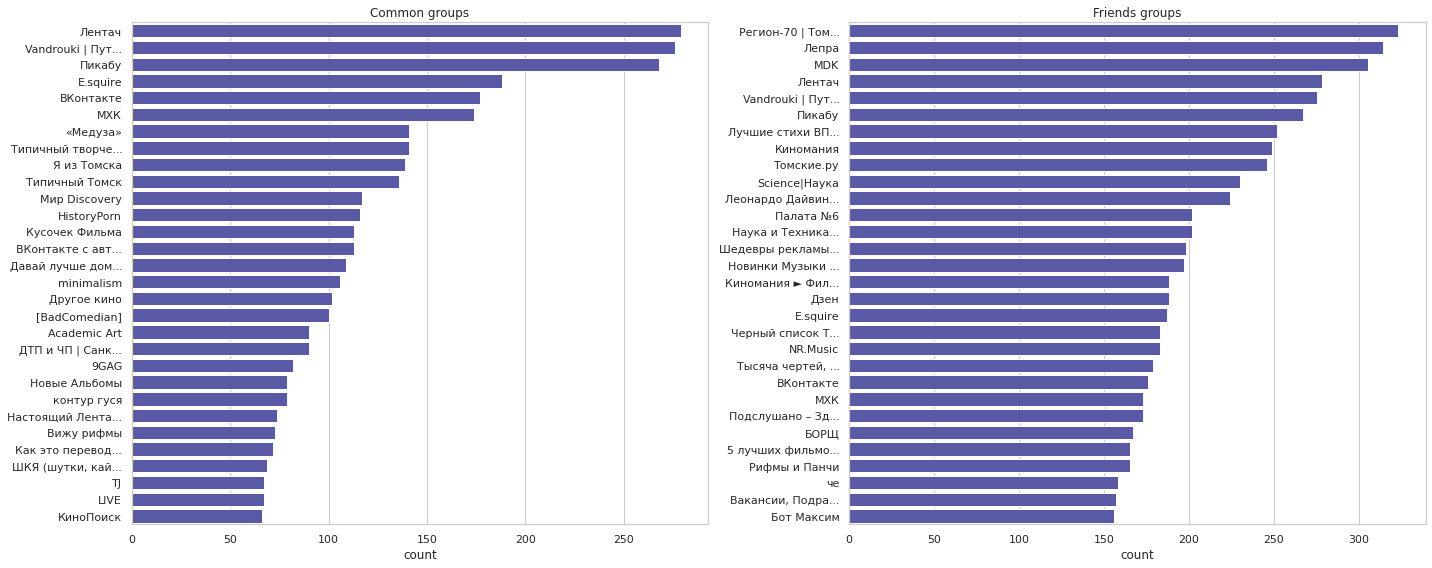

In [76]:
group_freq_vizualization(commons_friends_of_friends_groups_freq['count'], commons_friends_of_friends_groups_freq['name'], freinds_of_friends_groups_freq['count'], freinds_of_friends_groups_freq['name'])

Распределение частоты сообществ немного изменилось.
Выделилась явная тройка лидеров по общим группам - это Лентач, Vandoruki, Пикабу. Но подавляющее число групп друзей друзей не входит в круг интересов пользователя. Явно преобладают люди из города Томск, много развлекательных групп и групп о творчестве (музыка, кино и даже стихи - 7 место)

### 3. 

Встает вопрос, а что с этой информацией делать?

**Гипотеза**. Предложить пользователю в друзья тех людей, с которыми у него много общих групп. Это позволит расширить социальный граф пользователя, он может начать с нимим знакомиться, общаться, тем самым начнёт проводить больше времени в социальной сети. Это способствует повышению удержанию (Retention'у) - одной из ключевых метрик продукта.

In [88]:
list_people_numb_common_groups = list_groups_of_friends_of_friends_df[list_groups_of_friends_of_friends_df.id.isin(user_groups_df.id)]\
                                    .groupby('user_friend_id')\
                                    .agg({'name': 'count'})\
                                    .sort_values(by='name', ascending=False)\
                                    .rename(columns={'name':'numb_of_common_groups'})\
                                    .reset_index()
list_people_numb_common_groups.head()

,user_friend_id,numb_of_common_groups
0,508742,42
1,66226692,31
2,23530185,31
3,35704901,31
4,56491468,30


В целом, результат получен. Мы имеем список id-пользователей, которые имеют наибольшее количество общих групп с изначальным пользователем. 


При первом же просмотре этих людей выяснилось, что они имеют мало общего с пользователем, так как связаны через друга, у которого большое количество друзей, больше тысячи. Это страницы популярных людей, музыкальны групп, коллективов, которые на себе объединяют большое количество посторонних людей.

Чтобы как-то улучшить данный подход можно исключить из выборки тех друзей пользователя, у которых количество друзей больше определенного порога, например, 1000. Это наивный подход, но подобрав оптимальное количество друзей для отсечки, можно с определенной точностью гарантировать, что пользователь и его друг знакомы и использовать эти данные для расширения списка знакомств пользователя через знакомых его друга, знакомые знакомых.

На этом шаге можно не останавливаться, а подобрать дополнительные критерии для отбора предлагаемых в друзья людей. Например, считать количество лайков/просмотров/визитов в определенные группы и матчить между собой тех людей, которые отдают большие предпочтения определенным группам. Но средствами публичного API Вконтакте сделать это не представляется возможным, но внутренние инструменты Вконтакте, уверен, могут позволить это сделать.